Code to compute Kevin Tory's DWI using projections, from the article Developing simple fire-weather indices using dewpoint depression and windspeed: Application to Australian Eucalypt forests.

Basic formula is: DWI = (DPD + A)/B * (V + C)/D where DPD is the dewpoint depression, V is the wind speed, A, B, C, D are constants defined in the paper. 

As projections to not produce Td, we will have to compute it from temperatue and relative humidity. We will use tasmax and hursmin as we are computing the afternoon approximate fire weather value, other inputs will be needed for fireweather computations at other times of the day. 

Using the formula: Td = 243.5 [ln(rh/100) + 17.67T/(243.5 + T)]/(17.67 – [ln(rh/100) + 17.67T/(243.5 + T)])

The functions will take A, B, C, D as input to be applicable to possible future tunings of the simplified DWI to other fuels. 

In [5]:
import dask
from dask.distributed import Client, wait
from dask import delayed

#client = Client(n_workers=7, threads_per_worker=1) 
client = Client()

client

/g/data/xp65/public/apps/med_conda/envs/access-med-0.11/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38929 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/38929/status,
Dashboard: /proxy/38929/status,Workers: 4
Total threads: 4,Total memory: 18.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46659,Workers: 4
Dashboard: /proxy/38929/status,Total threads: 4
Started: Just now,Total memory: 18.00 GiB
Comm: tcp://127.0.0.1:45723,Total threads: 1
Dashboard: /proxy/33397/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:42395,


In [6]:
#import all the stuff
from netCDF4 import Dataset
import xarray as xr
import numpy as np
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import glob
import sys
sys.path.append("/g/data/mn51/users/nb6195/project/gwls/")
import gwl

In [35]:
#function to calculate dewpoint depression
#inputs: datasets of temperature and relative humidity
#outputs: a dataset of dewpoint depression
def calc_dpd(ds_temp, ds_rh):
    dpd = ds_temp - 243.5 * (np.log(ds_rh/100) + 17.67*ds_temp/(243.5 + ds_temp))/(17.67 - (np.log(ds_rh/100) + 17.67*ds_temp/(243.5 + ds_temp)))

    dpd.attrs = {
        'long_name': 'afternoon dewpoint depression computed from tasmax and hursmin',
        'standard_name': 'dpd',
        'units': 'degC',
#        'regrid_method': 'bilinear'
    }
    ds_dpd = xr.Dataset({'dpd' : dpd})
    ds_rh.close()
    ds_temp.close()
    
    return ds_dpd

In [57]:
def calc_dwi(ds_temp, ds_rh, ds_wind_sp, A, B, C, D):
    dwi = (calc_dpd(ds_temp, ds_rh)['dpd'] + A)/B * (ds_wind_sp + C)/D

    dwi.attrs = {
    'long_name': 'afternoon dry-windy index computed from tasmax, hursmin, maximum wind speed, and the tuned constants',
    'standard_name': 'dwi',
    'units': 'km h-1',
#    'regrid_method': 'bilinear'
    }
    ds_dwi = xr.Dataset({'dwi' : dwi})
    ds_rh.close()
    ds_temp.close()
    ds_wind_sp.close()
    return dwi

In [46]:
#Set parameters
CMIP='CMIP6'
#AGENCY = 'CSIRO' 
#RCM = 'CCAM-v2203-SN'
AGENCY = 'BOM' 
RCM = 'BARPA-R'

#GCM = 'ACCESS-CM2' #ensemble = 'r4i1p1f1' #Done
#GCM = 'ACCESS-ESM1-5' #ensemble = 'r6i1p1f1' #Done
GCM = 'EC-Earth3' 
ensemble = 'r1i1p1f1' #Done
#GCM = 'MPI-ESM1-2-HR' ensemble = 'r1i1p1f1' #BOM done, no CSIRO
#GCM = 'CESM2' ensemble = 'r11i1p1f1' #Done
#GCM = 'CMCC-ESM2' ensemble = 'r1i1p1f1' #Done
#GCM = 'NorESM2-MM' ensemble = 'r1i1p1f1' #Done
#GCM = 'CNRM-ESM2-1' ensemble = 'r1i1p1f2' #CSIRO Done, no BOM

#pathway = 'ssp126'
pathway = 'ssp370'

ddir = f"/g/data/kj66/CORDEX/output/{CMIP}/DD/AUST-05i/{AGENCY}/{GCM}"
output_dir = '/g/data/ia39/ncra/bushfire/dwi/test/'
#output_dir_mm = '/g/data/ia39/ncra/bushfire/dwi/monthly_mean/'

In [47]:
#read in RCM files
var1 = 'tasmax'
infiles1a=glob.glob(ddir+f'/historical/{ensemble}/{RCM}/v1-r1/day/{var1}/v20241216//{var1}_AUST-05i_{GCM}_historical_{ensemble}_{AGENCY}_{RCM}_v1-r1_day_*.nc')
infiles1b=glob.glob(ddir+f'/{pathway}/{ensemble}/{RCM}/v1-r1/day/{var1}/v20241216/{var1}_AUST-05i_{GCM}_{pathway}_{ensemble}_{AGENCY}_{RCM}_v1-r1_day_*.nc')
tasmax_master_ds = xr.open_mfdataset(infiles1a + infiles1b)

In [48]:
var2 = 'hursmin'
infiles2a=glob.glob(ddir+f'/historical/{ensemble}/{RCM}/v1-r1/day/{var2}/v20241216/{var2}_AUST-05i_{GCM}_historical_{ensemble}_{AGENCY}_{RCM}_v1-r1_day_*.nc')
infiles2b=glob.glob(ddir+f'/{pathway}/{ensemble}/{RCM}/v1-r1/day/{var2}/v20241216/{var2}_AUST-05i_{GCM}_{pathway}_{ensemble}_{AGENCY}_{RCM}_v1-r1_day_*.nc')
hursmin_master_ds = xr.open_mfdataset(infiles2a + infiles2b)

In [49]:
var3 = 'sfcWindmax'
infiles3a=glob.glob(ddir+f'/historical/{ensemble}/{RCM}/v1-r1/day/{var3}/v20241216/{var3}_AUST-05i_{GCM}_historical_{ensemble}_{AGENCY}_{RCM}_v1-r1_day_*.nc')
infiles3b=glob.glob(ddir+f'/{pathway}/{ensemble}/{RCM}/v1-r1/day/{var3}/v20241216/{var3}_AUST-05i_{GCM}_{pathway}_{ensemble}_{AGENCY}_{RCM}_v1-r1_day_*.nc')
wind_sp_master_ds = xr.open_mfdataset(infiles3a + infiles3b)

In [50]:
#Extract time period corresponding to the chosen GWL for tasmax and rh
chosen_gwl = '1.2'

gwl_tasmax = gwl.get_GWL_timeslice(tasmax_master_ds,CMIP,GCM,ensemble,pathway,GWL=chosen_gwl)[var1]
gwl_rh = gwl.get_GWL_timeslice(hursmin_master_ds,CMIP,GCM,ensemble,pathway,GWL=chosen_gwl)[var2]
gwl_wind_sp = gwl.get_GWL_timeslice(wind_sp_master_ds,CMIP,GCM,ensemble,pathway,GWL=chosen_gwl)[var3]

In [51]:
#Vesta DWI
#Values here from the paper provide an excellent approximation for 
#windspeeds between 10 and 80 km\ h^{-1}, using the longest unburned 
#fuel settings (10+ years) provided in Table 6 of Cheney et al. (2012).  
A = 5
B = 20
C = 0
D = 25

In [33]:
#function testing
#gwl_dpd = calc_dpd(gwl_tasmax, gwl_rh)

In [31]:
#gwl_dpd

In [32]:
#plt.imshow(gwl_dpd['dpd'][50], origin='lower')
#plt.colorbar()

In [58]:
#function testing
gwl_dwi = calc_dwi(gwl_tasmax, gwl_rh, gwl_wind_sp, A, B, C, D)

In [59]:
gwl_dwi

<xarray.DataArray (time: 7305, lat: 691, lon: 886)> Size: 18GB
dask.array<truediv, shape=(7305, 691, 886), dtype=float32, chunksize=(1, 691, 886), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 58kB 2004-01-01T12:00:00 ... 2023-12-31T12...
  * lat      (lat) float64 6kB -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon      (lon) float64 7kB 112.0 112.0 112.1 112.2 ... 156.2 156.2 156.2
Attributes:
    long_name:      afternoon dry-windy index computed from tasmax, hursmin, ...
    standard_name:  dwi
    units:          km h-1

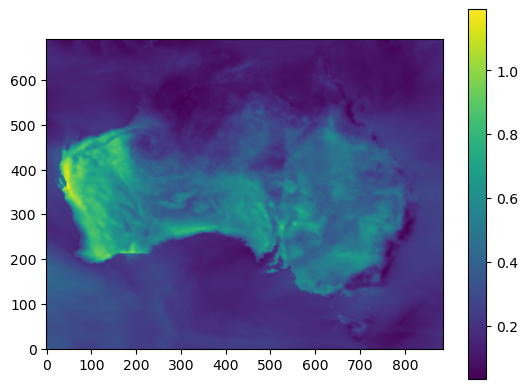

In [61]:
plt.imshow(gwl_dwi[50], origin='lower')
plt.colorbar()

In [ ]:
#DWI-based FWI approximating Vesta Mk 2, is comprised of two DWIs with a 
#linear transition between them 